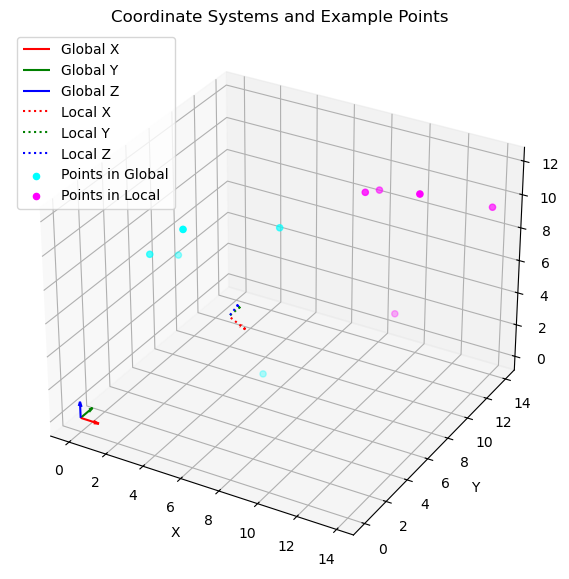

Reconstructed Global Points:
 [[5.33976182 7.47821317 0.05829117]
 [0.66984346 5.17494841 7.23726697]
 [2.74197869 4.79909112 9.59997133]
 [0.88218033 7.30816729 6.07715524]
 [5.41176059 8.93933639 8.29376481]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D rotation matrix
def rotation_matrix(axis, angle):
    axis = axis / np.linalg.norm(axis)
    cos_theta = np.cos(angle)
    sin_theta = np.sin(angle)
    ux, uy, uz = axis
    return np.array([
        [cos_theta + ux**2 * (1 - cos_theta), ux * uy * (1 - cos_theta) - uz * sin_theta, ux * uz * (1 - cos_theta) + uy * sin_theta],
        [uy * ux * (1 - cos_theta) + uz * sin_theta, cos_theta + uy**2 * (1 - cos_theta), uy * uz * (1 - cos_theta) - ux * sin_theta],
        [uz * ux * (1 - cos_theta) - uy * sin_theta, uz * uy * (1 - cos_theta) + ux * sin_theta, cos_theta + uz**2 * (1 - cos_theta)]
    ])

# Define the global coordinate system
origin_global = np.array([0, 0, 0])
axes_global = np.eye(3)  # Identity matrix (x, y, z axes)

# Define the local coordinate system (rotated and translated)
translation = np.array([5, 5, 5])
rotation = rotation_matrix(axis=np.array([0, 1, 0]), angle=np.pi / 6)  # Rotate around the Y-axis by 30 degrees
origin_local = translation
axes_local = rotation @ axes_global

# Generate example points in the global system
points_global = np.random.rand(5, 3) * 10

# Transform points to the local system
points_local = (rotation @ points_global.T).T + translation

# Visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot global coordinate system
ax.quiver(*origin_global, *axes_global[:, 0], color='r', label='Global X')
ax.quiver(*origin_global, *axes_global[:, 1], color='g', label='Global Y')
ax.quiver(*origin_global, *axes_global[:, 2], color='b', label='Global Z')

# Plot local coordinate system
ax.quiver(*origin_local, *axes_local[:, 0], color='r', linestyle='dotted', label='Local X')
ax.quiver(*origin_local, *axes_local[:, 1], color='g', linestyle='dotted', label='Local Y')
ax.quiver(*origin_local, *axes_local[:, 2], color='b', linestyle='dotted', label='Local Z')

# Plot points
ax.scatter(*points_global.T, color='cyan', label='Points in Global')
ax.scatter(*points_local.T, color='magenta', label='Points in Local')

# Plot settings
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Coordinate Systems and Example Points")
plt.show()

# Transform points back from local to global
points_global_reconstructed = (rotation.T @ (points_local - translation).T).T
print("Reconstructed Global Points:\n", points_global_reconstructed)


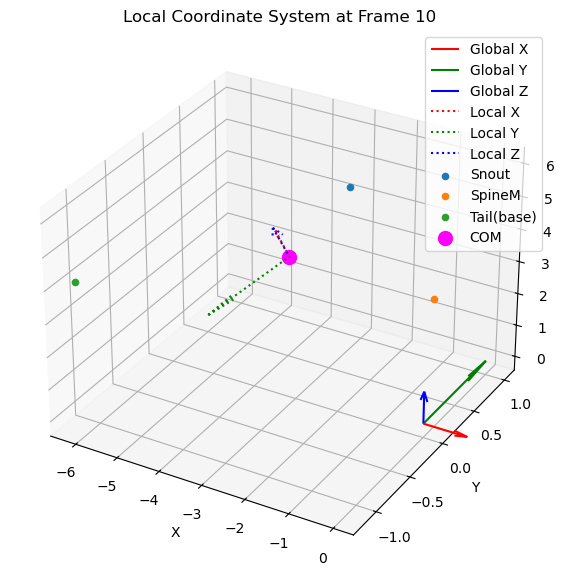

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Simulate mouse keypoints (e.g., Snout, SpineM, and Tail base)
# These points define the posture and allow for COM calculation
num_frames = 50
keypoints = {
    'Snout': np.cumsum(np.random.randn(num_frames, 3), axis=0),
    'SpineM': np.cumsum(np.random.randn(num_frames, 3), axis=0),
    'Tail(base)': np.cumsum(np.random.randn(num_frames, 3), axis=0)
}

# Compute Center of Mass (COM) dynamically
com_positions = (keypoints['Snout'] + keypoints['SpineM'] + keypoints['Tail(base)']) / 3

# Define dynamic local coordinate axes (aligned with the mouse posture)
local_axes = []
for i in range(num_frames):
    forward = keypoints['Snout'][i] - keypoints['SpineM'][i]
    forward /= np.linalg.norm(forward)
    up = np.cross(forward, keypoints['Tail(base)'][i] - keypoints['SpineM'][i])
    up /= np.linalg.norm(up)
    right = np.cross(up, forward)
    local_axes.append(np.stack([right, up, forward]))

local_axes = np.array(local_axes)  # Shape: (num_frames, 3, 3)

# Visualization for a single frame
frame_to_visualize = 10
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot global coordinate system
ax.quiver(0, 0, 0, 1, 0, 0, color='r', label='Global X')
ax.quiver(0, 0, 0, 0, 1, 0, color='g', label='Global Y')
ax.quiver(0, 0, 0, 0, 0, 1, color='b', label='Global Z')

# Plot local coordinate system at COM for the chosen frame
com = com_positions[frame_to_visualize]
axes = local_axes[frame_to_visualize]
ax.quiver(*com, *axes[:, 0], color='r', linestyle='dotted', label='Local X')
ax.quiver(*com, *axes[:, 1], color='g', linestyle='dotted', label='Local Y')
ax.quiver(*com, *axes[:, 2], color='b', linestyle='dotted', label='Local Z')

# Plot keypoints
for name, points in keypoints.items():
    ax.scatter(*points[frame_to_visualize], label=name)

# Plot Center of Mass
ax.scatter(*com, color='magenta', label='COM', s=100)

# Settings
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title(f"Local Coordinate System at Frame {frame_to_visualize}")
plt.show()


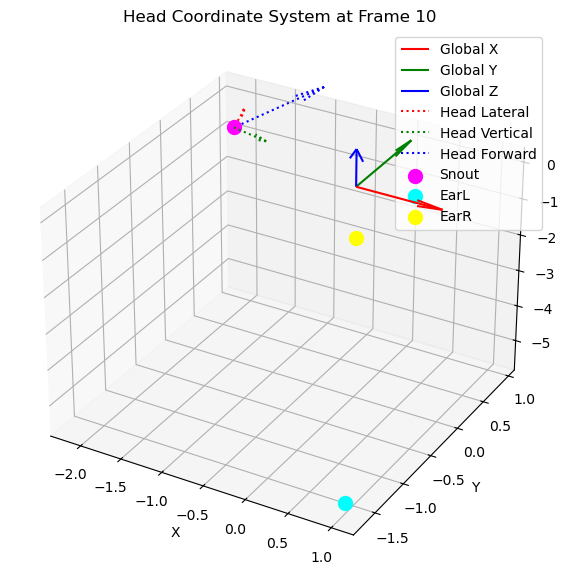

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Simulate mouse head keypoints (Snout, EarL, EarR)
num_frames = 50
keypoints = {
    'Snout': np.cumsum(np.random.randn(num_frames, 3), axis=0),
    'EarL': np.cumsum(np.random.randn(num_frames, 3), axis=0),
    'EarR': np.cumsum(np.random.randn(num_frames, 3), axis=0)
}

# Compute head coordinate system for each frame
head_axes = []
for i in range(num_frames):
    snout = keypoints['Snout'][i]
    ear_l = keypoints['EarL'][i]
    ear_r = keypoints['EarR'][i]
    
    # Define axes
    head_base = (ear_l + ear_r) / 2  # Midpoint between ears
    forward = snout - head_base  # Head direction (forward)
    forward /= np.linalg.norm(forward)
    
    lateral = ear_r - ear_l  # Left-right axis
    lateral /= np.linalg.norm(lateral)
    
    vertical = np.cross(lateral, forward)  # Perpendicular to head plane
    vertical /= np.linalg.norm(vertical)
    
    head_axes.append(np.stack([lateral, vertical, forward]))

head_axes = np.array(head_axes)  # Shape: (num_frames, 3, 3)

# Visualization for a single frame
frame_to_visualize = 10
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot global coordinate system
ax.quiver(0, 0, 0, 1, 0, 0, color='r', label='Global X')
ax.quiver(0, 0, 0, 0, 1, 0, color='g', label='Global Y')
ax.quiver(0, 0, 0, 0, 0, 1, color='b', label='Global Z')

# Plot head coordinate system at Snout
snout = keypoints['Snout'][frame_to_visualize]
axes = head_axes[frame_to_visualize]
ax.quiver(*snout, *axes[:, 0], color='r', linestyle='dotted', label='Head Lateral')
ax.quiver(*snout, *axes[:, 1], color='g', linestyle='dotted', label='Head Vertical')
ax.quiver(*snout, *axes[:, 2], color='b', linestyle='dotted', label='Head Forward')

# Plot keypoints
ax.scatter(*keypoints['Snout'][frame_to_visualize], color='magenta', label='Snout', s=100)
ax.scatter(*keypoints['EarL'][frame_to_visualize], color='cyan', label='EarL', s=100)
ax.scatter(*keypoints['EarR'][frame_to_visualize], color='yellow', label='EarR', s=100)

# Settings
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title(f"Head Coordinate System at Frame {frame_to_visualize}")
plt.show()


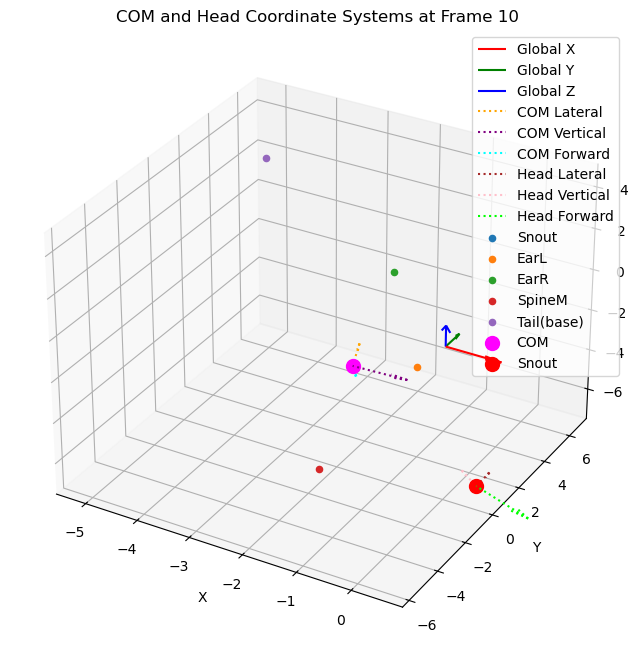

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Simulate mouse keypoints for body and head
num_frames = 50
keypoints = {
    'Snout': np.cumsum(np.random.randn(num_frames, 3), axis=0),
    'EarL': np.cumsum(np.random.randn(num_frames, 3), axis=0),
    'EarR': np.cumsum(np.random.randn(num_frames, 3), axis=0),
    'SpineM': np.cumsum(np.random.randn(num_frames, 3), axis=0),
    'Tail(base)': np.cumsum(np.random.randn(num_frames, 3), axis=0)
}

# Compute Center of Mass (COM)
com_positions = (keypoints['Snout'] + keypoints['SpineM'] + keypoints['Tail(base)']) / 3

# Compute COM coordinate system axes
com_axes = []
for i in range(num_frames):
    forward = keypoints['Snout'][i] - com_positions[i]  # Forward axis
    forward /= np.linalg.norm(forward)
    
    up = np.cross(forward, keypoints['Tail(base)'][i] - com_positions[i])  # Perpendicular axis
    up /= np.linalg.norm(up)
    
    lateral = np.cross(up, forward)  # Lateral axis
    com_axes.append(np.stack([lateral, up, forward]))

com_axes = np.array(com_axes)

# Compute head coordinate system axes
head_axes = []
for i in range(num_frames):
    snout = keypoints['Snout'][i]
    ear_l = keypoints['EarL'][i]
    ear_r = keypoints['EarR'][i]
    
    head_base = (ear_l + ear_r) / 2  # Midpoint of the ears
    forward = snout - head_base  # Forward axis
    forward /= np.linalg.norm(forward)
    
    lateral = ear_r - ear_l  # Left-right axis
    lateral /= np.linalg.norm(lateral)
    
    vertical = np.cross(lateral, forward)  # Perpendicular axis
    vertical /= np.linalg.norm(vertical)
    
    head_axes.append(np.stack([lateral, vertical, forward]))

head_axes = np.array(head_axes)

# Visualization for a single frame
frame_to_visualize = 10
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot global coordinate system
ax.quiver(0, 0, 0, 1, 0, 0, color='r', label='Global X')
ax.quiver(0, 0, 0, 0, 1, 0, color='g', label='Global Y')
ax.quiver(0, 0, 0, 0, 0, 1, color='b', label='Global Z')

# Plot COM coordinate system
com = com_positions[frame_to_visualize]
com_axes_frame = com_axes[frame_to_visualize]
ax.quiver(*com, *com_axes_frame[:, 0], color='orange', linestyle='dotted', label='COM Lateral')
ax.quiver(*com, *com_axes_frame[:, 1], color='purple', linestyle='dotted', label='COM Vertical')
ax.quiver(*com, *com_axes_frame[:, 2], color='cyan', linestyle='dotted', label='COM Forward')

# Plot Head coordinate system
snout = keypoints['Snout'][frame_to_visualize]
head_axes_frame = head_axes[frame_to_visualize]
ax.quiver(*snout, *head_axes_frame[:, 0], color='brown', linestyle='dotted', label='Head Lateral')
ax.quiver(*snout, *head_axes_frame[:, 1], color='pink', linestyle='dotted', label='Head Vertical')
ax.quiver(*snout, *head_axes_frame[:, 2], color='lime', linestyle='dotted', label='Head Forward')

# Plot keypoints
for name, points in keypoints.items():
    ax.scatter(*points[frame_to_visualize], label=name)

# Plot COM and Snout
ax.scatter(*com, color='magenta', label='COM', s=100)
ax.scatter(*snout, color='red', label='Snout', s=100)

# Settings
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title(f"COM and Head Coordinate Systems at Frame {frame_to_visualize}")
plt.show()
